<h1> Ensemble generation submission and analysis notebook </h1>

This script will:

<ol>
<li>Clone github repo 
<li>Make and build a default 4x5 CLM-FATES case
<li>Make an ensemble of CLM-FATES cases 
<li>Generate an ensemble of parameter files with one at a time or latin hypercube  modification
<li>Point each ensemble member at a different parameter file
<li>Submit all these jobs
<li>Analyse output
</ol>

<h4>n.b. This notebook is also set up to work with Cheyenne specific paths, but can be modified. 

#### Control variables for the analysis script.

In [1]:
# This mega script does 
# ensemble setup (including parameter file generation.  
# job submission and 
# analysis. 

# You can turn these off and on according to where you are tin the process. 

dosetup = 1 #do we want to create parameters files and so on?
dosubmit = 1 #do we do the submission stage, or just the analysis?
forcenewcase = 0 #do we scurb all the old cases and start again?
doanalysis = 1 #do we want to plot the outputs? 
print("setup, submit, analysis:", dosetup,dosubmit,doanalysis)

setup, submit, analysis: 1 1 1


In [2]:
#import things. Not sure if all of these are still strictly necessary. 
from multiprocessing.pool import ThreadPool
import dask
dask.config.set(scheduler='single-threaded')
import os
import netCDF4 as nc4
import sys
import shutil
import numpy as np

<h3>Set global variables and paths for ensemble analysis </h3>

In [3]:
# FATES mode settings for the ensemble
sp=1 #are we using SP mode?
calib=1 # this script can be run in one at a time and latin hypercube mode.
calibvars=2 #which set of variables are we peturbing?
n=1 #the number of the ensemble. For when you need to do it all again ;) 
dim3=0

### Set pathnames for parameter directories and casenames.

In [4]:
# what is your clone of the ctsm repo called? (or you want it to be called?) 
ctsmrepo='ctsmsep22'

#what do you want the directory with the ensemble cases in to be called?
ens_directory='RTM_ens'+str(n)

#what do you want the case names to begin with?
caseroot=ens_directory+'_case_'

#path to scratch (or where the model is built.)
defbuildroot='/glade/scratch/'

#how many members are in the ensemble?
ncases=12 

#where are we now?
notebookdr=os.getcwd()  

USER='rfisher'

#### SP/NOCOMP specific paths to default case/param files

In [5]:
if(sp == 1): #Settings for the SP ensemble.
    resub=0 #how many times to resubmit the model. 

    #what is the name of your 'basecase'?
    defcase='fates_crops_smo_minlai_opt_vcmax50'
    
    #what is the base parameter file called?
    paramfiledefault='fates_params_default.nc'    

else: #Settings for the NOCOMP ensemble. 
    resub=2 #how many times do we want to resubmit the job?
    
    #what is the name of your 'basecase'?
    defcase='SPdefault_sept'
    
    #what is the base parameter file called?
    paramfiledefault='param_files_nocomp_'+str(n)   
    paramfiledefault='/glade/u/home/rfisher/fates_sp_ensembles/param_files_sp_n6_noc4/calib_paramfiledefault.nc'
    
print(caseroot)


RTM_ens1_case_


#### Clone CTSM repo (if necessary).

##### (This box and others like it go into BASH script 'mode', and hence isn't in python) 

In [6]:
%%bash -s "$ctsmrepo" "$dosetup"
ctsmrepo=$1
dosetup=$2

if [ $dosetup -eq 1 ]
then
cd /glade/work/$USER/
#go to git directory
if [[ -d "git" ]]
then
cd git
else
mkdir git
cd git
fi

#go to git repo, or checkout code
if [[ -d "$ctsmrepo" ]]
then
cd $ctsmrepo
echo "Already have ctsm repo"
else
echo "Cloning ctsm"
#clone CTSM code if you didn't to this already. 
#git clone https://github.com/escomp/ctsm $ctsmrepo
cd $ctsmrepo
#./manage_externals/checkout_externals
cd src
fi
fi
echo "Currently in" $(pwd)

Already have ctsm repo
Currently in /glade/work/rfisher/git/ctsmsep22


<h4> Make a default FATES 4x5 case (this will take a while if it has to build) </h4>

In [7]:
%%bash -s "$ctsmrepo" "$dosetup" "$defcase" 
ctsmrepo=$1
dosetup=$2
defcase=$3
echo "defcase is" $defcase
echo "setup=" $dosetup
echo $dosetup
compset=2000_DATM%GSWP3v1_CLM50%FATES_SICE_SOCN_MOSART_SGLC_SWAV_SESP
if [[ $dosetup -eq 1 ]]
then
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
if [[ -d "$defcase" ]]
then
    echo "$defcase exists on your filesystem." .$defcase
else
    echo "making defcase.",$defcase
./create_newcase --case $defcase --compset 2000_DATM%GSWP3v1_CLM50%FATES_SICE_SOCN_MOSART_SGLC_SWAV_SESP --res f45_f45_mg37  --run-unsupported
cd $defcase
./case.setup
./case.build
fi
fi
echo "Currently in" $(pwd)

defcase is fates_crops_smo_minlai_opt_vcmax50
setup= 1
1
fates_crops_smo_minlai_opt_vcmax50 exists on your filesystem. .fates_crops_smo_minlai_opt_vcmax50
Currently in /glade/work/rfisher/git/ctsmsep22/cime/scripts


#### Adjust settings of default case. 

In [8]:
%%bash -s "$ctsmrepo" "$defcase" "$dosetup" "$defbuildroot" 

ctsmrepo=$1
defcase=$2
dosetup=$3
defbuildroot=$4

if [[ $dosetup -eq 1 ]]
then
defbld=$defbuildroot$USER/$defcase/bld
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts/$defcase

echo 'updating settings'
./xmlchange CONTINUE_RUN=FALSE;  
./xmlchange --id STOP_N --val 5;  #number of years of simulation
./xmlchange --id STOP_OPTION --val nyears;
./xmlchange --id CLM_FORCE_COLDSTART --val on;
echo "Currently in" $(pwd)
fi

updating settings
Currently in /glade/work/rfisher/git/ctsmsep22/cime/scripts/fates_crops_smo_minlai_opt_vcmax50


#### Make a default user_nl_clm file

In [9]:
%%bash -s "$ctsmrepo" "$defcase" "$dosetup" "$ens_directory" "$sp"

ctsmrepo=$1
defcase=$2
dosetup=$3
ens_directory=$4
usesp=$5

if [[ $dosetup -eq 1 ]]
then
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
cd $defcase

if [ -f "user_nl_clm_store" ] #did we do this already?
then
#move the stored version to the default version
cp user_nl_clm_store  user_nl_clm_default
else
#store the 'vanilla' user_nl_clm file
cp user_nl_clm  user_nl_clm_store
# and then make a copy of that to act as the default for the ensemble. 
cp user_nl_clm_store  user_nl_clm_default
fi 

if [[ $usesp -eq 1 ]] #change to SP mode. 
then
echo use_fates_sp=.true. >> user_nl_clm_default
fi
 
echo "Currently in" $(pwd)
cp user_nl_clm_default ../$ens_directory/user_nl_clm_default
fi

#n.b. i overwrote this with a file in the ensemble directory last time i did it.

Currently in /glade/work/rfisher/git/ctsmsep22/cime/scripts/fates_crops_smo_minlai_opt_vcmax50


<h3> Make ensemble of cases.</h3>

In [10]:
%%capture
%%bash -s "$ctsmrepo" "$defcase" c "$ens_directory" "$caseroot" "$ncases" "$forcenewcase"

ctsmrepo=$1
defcase=$2
dosetup=$3
ens_directory=$4
caseroot=$5
ncases=$6
forcenewcase=$7

echo "ncases=" $ncases
echo "caseroot=" $caseroot
echo "dosetup=" $dosetup
echo "forcenewcase=" $forcenewcase
echo "ens_directory=" $ens_directory

if [[ $dosetup -eq 1 ]]
then
echo "setup"

cd /glade/work/$USER/git/$ctsmrepo/cime/scripts

if [[ -d "$ens_directory" ]]
then
echo "already have ensemble directory"
else
mkdir $ens_directory
fi 

#make directory for parameter files. 
cd $ens_directory
if [[ -d "parameter_files" ]]
then
echo "already have parameter_files directory"
else
mkdir parameter_files
fi 
cd ..

counter1=0 #include a default zero case. 
while [ $counter1 -le $ncases ]
do
  newcase=$caseroot$counter1 #name of ensemble membr case.    
  if [ -d $ens_directory/$newcase ]
  then
    echo ' new case already exists',$ens_directory/$newcase
    if [ $forcenewcase -eq 1 ]
    then
    echo 'force making case', $ens_directory/$newcase
    rm -rf $ens_directory/$newcase
    ./create_clone --clone $defcase --case $ens_directory/$newcase ;
    fi    
  else
   echo 'making new case', $ens_directory/$newcase
    ./create_clone --clone $defcase --case $ens_directory/$newcase ;
  fi
((counter1++))
done

counter1=0 #include a default zero case. 
while [ $counter1 -le $ncases ]
do
  newcase=$caseroot$counter1 #name of ensemble membr case.   
   cd $ens_directory/$newcase
   echo 'case setup', $ens_directory/$newcase
   ./case.setup;
    cd ../../ 
((counter1++))
done
fi

<h3> Create .nc version of current defualt file. I FAILED ATT THIS. NEEDS INPUT..</h3>
You currently have to do this step manually, by doing this in the terminal:

<i> cd /glade/work/$USER/git/$ctsmrepo/src/fates/parameter_files/</i><br>
<i>ncgen -o fates_params_default.nc fates_params_default.cdl </i>

#### Copy default .nc template parameter file to ensemble parameter directory . 

In [11]:
if(dosetup == 1): 
    paramsdir='/glade/work/'+USER+'/git/'+ctsmrepo+'/cime/scripts/'+ens_directory+'/parameter_files'
    defparamfile='/glade/work/'+USER+'/git/'+ctsmrepo+'/src/fates/parameter_files/'+paramfiledefault
    !cp $defparamfile $paramsdir
    filename_template = paramsdir+'/'+paramfiledefault
    print(filename_template)

/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_default.nc


#### Make function for copying fates parameter files. 

In [12]:
def copy_clobber(filename1, filename2):
    try:
        os.remove(filename2) #replacing file
    except: #'file does not yet exist
        shutil.copyfile(filename1, filename2)

#### Make function to modify FATES parameter files. 

In [13]:
def def_pftfile( fileroot,i,variable,delta):   
    pfilename = fileroot+str(i)+'.nc' 
    print('modifying parameter file',i,variable,'x',delta);
    fin = nc4.Dataset(pfilename, 'r+')
    var = fin.variables[variable]
    var[:] = var[:]*delta
    fin.close()

#### Create ensemble of parameter files

In [19]:
if(dosetup == 1): 
    fatesparamfile= 'fates_params_'+ens_directory+'_'
    vs=range(0,ncases+1) 
    print(paramsdir)
    for i in vs:
        filename_out = paramsdir+'/'+fatesparamfile+str(i)+'.nc' 
        #print('making parameter file',i,fatesparamfile+str(i)+'.nc');
        print('making:'+filename_out)
        copy_clobber(filename_template,filename_out) ; 


/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files
making:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_0.nc
making:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_1.nc
making:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_2.nc
making:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_3.nc
making:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_4.nc
making:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_5.nc
making:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_6.nc
making:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_7.nc
making:/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/f

#### Modify parameters for senstivity analysis. 

In [20]:
parameter_list=['fates_rad_leaf_clumping_index','fates_rad_leaf_xl',
                'fates_rad_leaf_rhovis','fates_leaf_vcmax25top',
                'fates_rad_stem_tauvis','fates_rad_leaf_rhonir']

min_delta=[0.9,0.1,0.8,0.8,0.8,0.8]
max_delta=[1.1,10 ,1.2,1.2,1.2,1.2]
print(parameter_list)  

['fates_rad_leaf_clumping_index', 'fates_rad_leaf_xl', 'fates_rad_leaf_rhovis', 'fates_leaf_vcmax25top', 'fates_rad_stem_tauvis', 'fates_rad_leaf_rhonir']


In [21]:
#n.b. I (RAF) have other scripts that do LHC sampling or n dimensional arrays. 
#just inclusing this one at a time example here for simplicity. 
if(dosetup == 1): 
    fileroot =  paramsdir+'/'+fatesparamfile 
    print(fileroot)
    if(sp == 1):
        for p in range(0,6):
            print(p,p*2-1)
            def_pftfile(fileroot,p*2+1,parameter_list[p],min_delta[p])
            def_pftfile(fileroot,p*2+2,parameter_list[p],max_delta[p])


/glade/work/rfisher/git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files/fates_params_RTM_ens1_
0 -1
modifying parameter file 1 fates_rad_leaf_clumping_index x 0.9
modifying parameter file 2 fates_rad_leaf_clumping_index x 1.1
1 1
modifying parameter file 3 fates_rad_leaf_xl x 0.1
modifying parameter file 4 fates_rad_leaf_xl x 10
2 3
modifying parameter file 5 fates_rad_leaf_rhovis x 0.8
modifying parameter file 6 fates_rad_leaf_rhovis x 1.2
3 5
modifying parameter file 7 fates_leaf_vcmax25top x 0.8
modifying parameter file 8 fates_leaf_vcmax25top x 1.2
4 7
modifying parameter file 9 fates_rad_stem_tauvis x 0.8
modifying parameter file 10 fates_rad_stem_tauvis x 1.2
5 9
modifying parameter file 11 fates_rad_leaf_rhonir x 0.8
modifying parameter file 12 fates_rad_leaf_rhonir x 1.2


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


#### Point each ensemble script at different parameter file

In [52]:
%%bash -s "$ctsmrepo" "$fatesparamfile" "$ens_directory" "$caseroot" "$dosetup" "$ncases" "$paramsdir"


ctsmrepo=$1
fatesparamfile=$2
ens_directory=$3
caseroot=$4
dosetup=$5
ncases=$6
paramsdir=$7

if [ $dosetup -eq 1 ]
then
echo "Writing parameter file names into user_nl_clm files"
unl=user_nl_clm
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
counter1=0
cd $ens_directory

while [[ $counter1 -le $ncases ]]
do
  #echo $counter1
  newcase=$caseroot$counter1 
  pftfilename=$fatesparamfile$counter1
  echo "pftfilename = "  $pftfilename
  if [ -d $newcase ]
  then
   cd $newcase
   #get default parameter file
    cp ../user_nl_clm_default user_nl_clm
    sed -i "s|fates_params_default|$pftfilename|g" user_nl_clm
    cd ../
  else
   echo 'no case', $newcase
  fi

  ((counter1++))
  done
#cat $newcase/user_nl_clm

fi

Writing parameter file names into user_nl_clm files
pftfilename =  fates_params_RTM_ens1_0
pftfilename =  fates_params_RTM_ens1_1
pftfilename =  fates_params_RTM_ens1_2
pftfilename =  fates_params_RTM_ens1_3
pftfilename =  fates_params_RTM_ens1_4
pftfilename =  fates_params_RTM_ens1_5
pftfilename =  fates_params_RTM_ens1_6
pftfilename =  fates_params_RTM_ens1_7
pftfilename =  fates_params_RTM_ens1_8
pftfilename =  fates_params_RTM_ens1_9
pftfilename =  fates_params_RTM_ens1_10
pftfilename =  fates_params_RTM_ens1_11
pftfilename =  fates_params_RTM_ens1_12


<h3>Submit ensemble of cases</h3>

In [53]:
%%capture
%%bash -s "$ctsmrepo" "$defcase" "$ens_directory" "$caseroot" "$ncases" "$dosubmit" 

ctsmrepo=$1
defcase=$2
ens_directory=$3
caseroot=$4
ncases=$5
dosubmit=$6

if [ $dosubmit -eq 1 ]
then
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
echo 'submitting'
startcase=0
counter1=$startcase
cd $ens_directory
pwd

while [ $counter1 -le $ncases ]
do
  echo $counter1
  newcase=$caseroot$counter1
  echo $newcase

  if [ -d $newcase ]
  then
    cd $newcase
    echo 'submitting job',$newcase
    ./xmlchange BUILD_COMPLETE=TRUE
    #./xmlchange RESUBMIT=1
   # ./xmlchange PROJECT=P93300041
    ./case.submit
    cd ../
  else
   echo 'no case', $newcase
  fi

  ((counter1++))
  done
else
echo "not submitting jobs"
fi

<h2>Analyse output</h2>

### Import libraries for analysis

In [31]:
%matplotlib inline
if doanalysis ==1:
    import numpy as np
    import warnings
    warnings.filterwarnings('ignore')
    import xarray as xr
    from matplotlib import pyplot as plt
    import datetime
    import cartopy
    import cartopy.crs as ccrs
    import os.path
    import xesmf as xe

In [38]:
if doanalysis ==1: 
    output='/glade/scratch/rfisher/'
    conv = 3600*24*365
    yr='.clm2.h0.'   
    ychoose=2000
    delta=1
    pftnames=['BlEvTrTr','NlEvTr','NlCdDecTt','BlEvTmTr','BlDrDecTt','BlCdDecTr','BlEvSh','BlDrDecSh','BlCdDecSh','C3AG','C3G']

<h3>Make output figure directory</h3>

In [28]:
#fig dir
figdirname='figs_'+ens_directory
print(figdirname)

figs_RTM_ens1


In [29]:
%%bash -s "$figdirname"  
figdirname=$1

cd $notebookdr
if [[ -d $figdirname ]]
then
   echo "existing fig firectory",$figdirname
else 
    mkdir $figdirname
    echo "made fig firectory", $figdirname
fi

made fig firectory, figs_RTM_ens1


<h3>Make a single data structure for the ensemble</h3>

In [35]:
if doanalysis ==1:
    vs=range(1|0,ncases+1) 
    print(vs)
    count=1
    ncol=3
    print(caseroot)
    for i in vs:
        print(i)
        run=caseroot+str(i)
        arc = output + 'archive/' + run + '/lnd/hist/'
        f2= arc + '/'+str(ychoose)+'combined.nc'
        if(os.path.isdir(arc)):
            arc = arc
        else:
            arc = output + run + '/run/'
            print('output in run dir')
        fileout = arc + '/'+str(ychoose)+'combined.nc'
        #os.remove(fileout)
        print(fileout)
        if(os.path.isfile(fileout)):
            print('file exists')
            arc=arc
        else:
            print('no file exists')
            print('fileroot:',arc +run+yr+str(ychoose)+'*')
            ds0 = xr.open_mfdataset(arc +run+yr+str(ychoose)+'*', decode_times=False)           
            ds0.to_netcdf(fileout)
            print(arc)

print('end')

range(1, 13)
RTM_ens1_case_
1
output in run dir
/glade/scratch/rfisher/RTM_ens1_case_1/run//2000combined.nc
no file exists
fileroot: /glade/scratch/rfisher/RTM_ens1_case_1/run/RTM_ens1_case_1.clm2.h0.2000*
/glade/scratch/rfisher/RTM_ens1_case_1/run/
2
output in run dir
/glade/scratch/rfisher/RTM_ens1_case_2/run//2000combined.nc
no file exists
fileroot: /glade/scratch/rfisher/RTM_ens1_case_2/run/RTM_ens1_case_2.clm2.h0.2000*
/glade/scratch/rfisher/RTM_ens1_case_2/run/
3
output in run dir
/glade/scratch/rfisher/RTM_ens1_case_3/run//2000combined.nc
no file exists
fileroot: /glade/scratch/rfisher/RTM_ens1_case_3/run/RTM_ens1_case_3.clm2.h0.2000*
/glade/scratch/rfisher/RTM_ens1_case_3/run/
4
output in run dir
/glade/scratch/rfisher/RTM_ens1_case_4/run//2000combined.nc
no file exists
fileroot: /glade/scratch/rfisher/RTM_ens1_case_4/run/RTM_ens1_case_4.clm2.h0.2000*
/glade/scratch/rfisher/RTM_ens1_case_4/run/
5
output in run dir
/glade/scratch/rfisher/RTM_ens1_case_5/run//2000combined.nc
no f

1
2
3
4
5
6
7
8
9
10
11
12
figs/ensemble_GPP_delta_abs_RTM_ens1_case_12.png


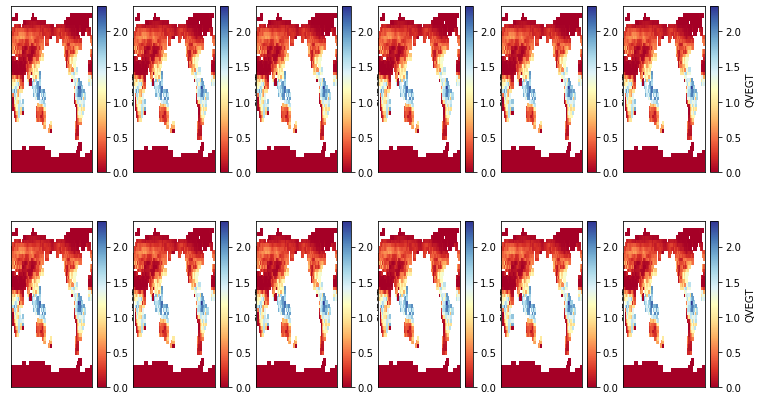

In [50]:
import time
rel=0

if doanalysis ==1:
    conv=24*3600
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [15,7]
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    vs=range(1,ncases+1)
    ncol=7
    nrow=2
    count=1
    for i in vs:
        index=((count+1) % 2)*ncol + ((count+1) // 2)
        print(i)
        ax = fig.add_subplot(nrow, ncol, index)
        count=count+1
        #ds0=dse1.isel(realization=i)
        #dsdef=dse1.isel(realization=0)
        mod=np.multiply(np.mean(ds0.QVEGT,0),conv)
        plt1=mod.plot(cmap='RdYlBu')
       
              
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        fig.canvas.draw()
        time.sleep(1) 
        
if(delta == 1):
    if(rel==1):
        fnmfig='figs/ensemble_GPP_delta_rel_'+caseroot +str(i)+'.png'
    else:
        fnmfig='figs/ensemble_GPP_delta_abs_'+caseroot +str(i)+'.png'       
else:
    if(rel==1):
        fnmfig='figs/ensemble_GPP_error_rel_'+caseroot +str(i)+'.png'
    else:
        fnmfig='figs/ensemble_GPP_error_abs_'+caseroot +str(i)+'.png'       

print(fnmfig)
plt.savefig(fnmfig)